# The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.
We use a very simple forward NN with a single hidden layer.

In [114]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest

In [142]:
# Define the forward function to compute the output of the neural network
def forward(X,i):
    Z1 = tf.add(tf.matmul(X, W1[:,:,i]), b1[:,i])
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2[:,:,i]), b2[:,i])
    Y = tf.nn.relu(Z2)
    return Z2

In [143]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 1000
output_size = 1
Nboot = 1000

# Initialize the weights and the bias with random number distributed with a gamma function
W1 = tf.Variable(tf.random.gamma([input_size, hidden_size, Nboot], alpha=1, beta=2), name='W1')
b1 = tf.Variable(tf.random.gamma([hidden_size, Nboot], alpha=1, beta=2), name='b1')
W2 = tf.Variable(tf.random.gamma([hidden_size, output_size, Nboot], alpha=1, beta=2), name='W2')
b2 = tf.Variable(tf.random.gamma([output_size, Nboot], alpha=1, beta=2), name='b2')


print(b1.numpy()[1,:].shape)
print(W1.numpy().shape)
print(W2.numpy().shape)


# We compute the output for each event for an input
X = tf.constant([[0.5]], dtype=tf.float32)
output_array = []
for i in range (0, Nboot):
    Y = forward(X,i)
    output_array.append(Y.numpy()[0][0])

(1000,)
(1, 1000, 1000)
(1000, 1, 1000)


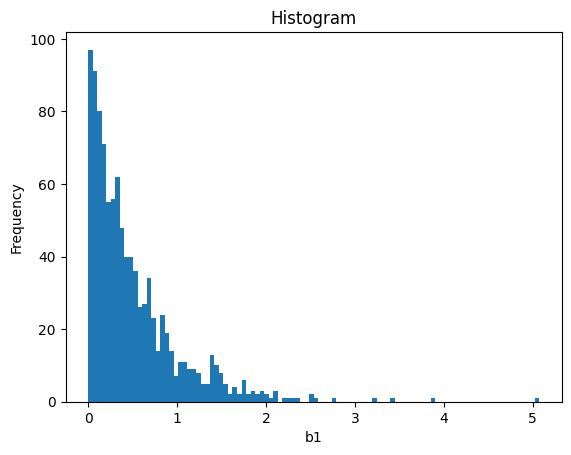

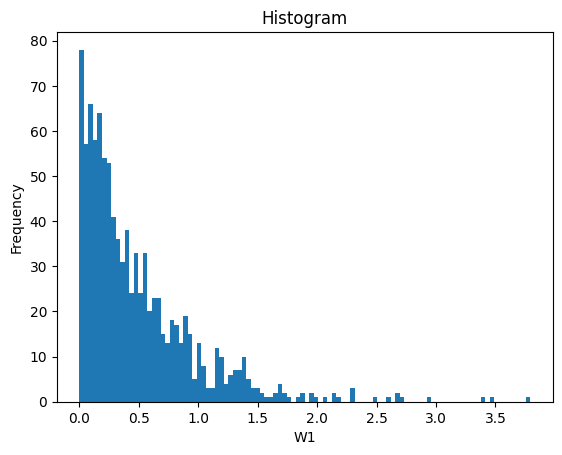

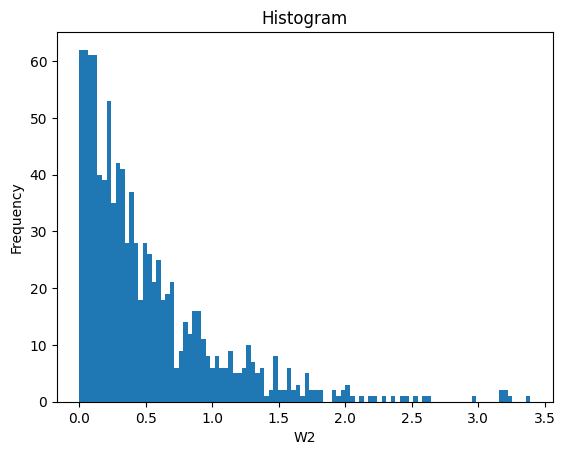

In [147]:
# Print the input distributions of the weights and bias
plt.hist(b1.numpy()[0,:], bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

plt.clf()

plt.hist(W1.numpy()[0,0,:], bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

plt.clf()


plt.hist(W2.numpy()[0,0,:], bins=100)
plt.xlabel('W2')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

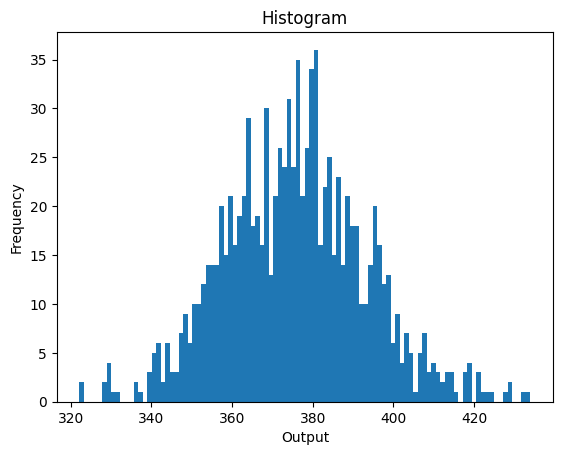

Data follow a gaussian distribution.


In [149]:
# Check the output distribution
plt.clf()
plt.hist(output_array, bins=100)
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()


# Test of the gaussianity
stat, p = normaltest(output_array)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")